# 13.11. 全卷积网络

如 13.9节中所介绍的那样，语义分割是对图像中的每个像素分类。 全卷积网络（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 ([Long et al., 2015](https://zh-v2.d2l.ai/chapter_references/zreferences.html#id100))。 与我们之前在图像分类或目标检测部分介绍的卷积神经网络不同，全卷积网络将中间层特征图的高和宽变换回输入图像的尺寸：这是通过在 13.10节中引入的转置卷积（transposed convolution）实现的。 因此，输出的类别预测与输入图像在像素级别上具有一一对应关系：通道维的输出即该位置对应像素的类别预测。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 13.11.1. 构造模型
下面我们了解一下全卷积网络模型最基本的设计。 如 图13.11.1所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1 \times 1$卷积层将通道数变换为类别个数，最后在 13.10节中通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。 因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。

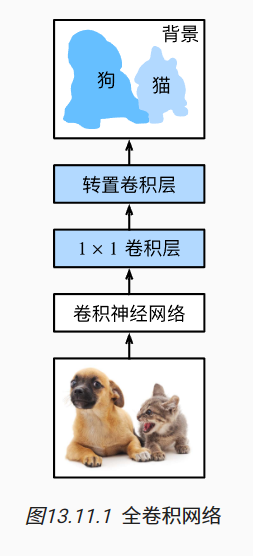

下面，我们使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征，并将该网络记为pretrained_net。 ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。

In [3]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\wmz/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:23<00:00, 2.01MB/s]


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

接下来，我们创建一个全卷积网络net。 它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。

In [4]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

给定高度为320和宽度为480的输入，net的前向传播将输入的高和宽减小至原来的$1/32$，即10和15。

In [5]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

d:\anaconda3\envs\pytorch190\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 512, 10, 15])

接下来使用$1 \times 1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。 最后需要将特征图的高度和宽度增加32倍，从而将其变回输入图像的高和宽。 回想一下 6.3节中卷积层输出形状的计算方法： 由于$(320-64+16 \times 2 + 32)/32=10$且$(480-64 + 16 \times 2 + 32)/32=15$，我们构造一个步幅为$32$的转置卷积层，并将卷积核的高和宽设为$64$，填充为$16$。 我们可以看到如果步幅为$s$，填充为$s/2$（假设$s/2$是整数）且卷积核的高和宽为$2s$，转置卷积核会将输入的高和宽分别放大$s$倍。

In [6]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

## 13.11.2. 初始化转置卷积层
在图像处理中，我们有时需要将图像放大，即上采样（upsampling）。 双线性插值（bilinear interpolation） 是常用的上采样方法之一，它也经常用于初始化转置卷积层。

为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。

1. 将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。 例如，根据输入与输出的尺寸之比来映射。 请注意，映射后的$x'$和$y'$是实数。
2. 在输入图像上找到离坐标$(x',y')$最近的4个像素。
3. 输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下bilinear_kernel函数构造。 限于篇幅，我们只给出bilinear_kernel函数的实现，不讨论算法的原理。

In [7]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

让我们用双线性插值的上采样实验它由转置卷积层实现。 我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。

In [8]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

读取图像X，将上采样的结果记作Y。为了打印图像，我们需要调整通道维的位置。

In [10]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('./img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

可以看到，转置卷积层将图像的高和宽分别放大了2倍。 除了坐标刻度不同，双线性插值放大的图像和在 13.3节中打印出的原图看上去没什么两样。

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


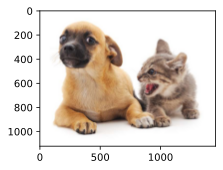

In [11]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

全卷积网络用双线性插值的上采样初始化转置卷积层。对于$1 \times 1$卷积层，我们使用Xavier初始化参数。

In [12]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## 13.11.3. 读取数据集
我们用 13.9节中介绍的语义分割读取数据集。 指定随机裁剪的输出图像的形状为$320 \times 480$：高和宽都可以被$32$整除。

In [13]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


## 13.11.4. 训练
现在我们可以训练全卷积网络了。 这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维。 此外，模型基于每个像素的预测类别是否正确来计算准确率。

ValueError: Expected a non cpu device, but got: cpu

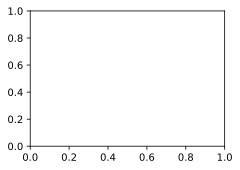

In [19]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3,  d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 13.11.5. 预测
在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [20]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

为了可视化预测的类别给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。

In [21]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

测试数据集中的图像大小和形状各异。 由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。 为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。 请注意，这些区域的并集需要完整覆盖输入图像。 当一个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的平均值可以作为softmax运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320 \times 480$的区域用于预测。 对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。

In [22]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

KeyboardInterrupt: 

## 13.11.6. 小结
- 全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1 \times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
- 在全卷积网络中，我们可以将转置卷积层初始化为双线性插值的上采样。

## 13.11.7. 练习
1. 如果将转置卷积层改用Xavier随机初始化，结果有什么变化？
2. 调节超参数，能进一步提升模型的精度吗？
3. 预测测试图像中所有像素的类别。
4. 最初的全卷积网络的论文中 ([Long et al., 2015](https://zh-v2.d2l.ai/chapter_references/zreferences.html#id100))还使用了某些卷积神经网络中间层的输出。试着实现这个想法。